In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
import os
import pickle
from pathlib import Path
import re
import matplotlib.patches as mpatches
import scipy.linalg as la
from scipy.stats import norm



In [29]:

def portfolio_stats_paper_style(returns,
                                periods_per_year=252,
                                rf_annual=0.0,
                                target=0.0,
                                alpha=0.95):

    r = pd.Series(returns).dropna().astype(float).to_numpy()
    if len(r) < 2:
        raise ValueError("need at least 2 observations")
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1)")

    mu = float(np.mean(r))
    sigma2 = float(np.var(r, ddof=0))
    sigma = float(np.sqrt(sigma2))

    mu_ann = mu * periods_per_year
    sigma2_ann = sigma2 * periods_per_year
    sigma_ann = float(np.sqrt(sigma2_ann))

    # downside RMS / LPM2
    downside = (r[r < target] - target)
    semivar = 0.0 if downside.size == 0 else float(np.mean(downside**2))
    semidev_ann = float(np.sqrt(semivar * periods_per_year))

    # VaR/CVaR
    q = 1.0 - alpha
    VaR = float(np.quantile(r, q))
    tail = r[r <= VaR]
    CVaR = VaR if tail.size == 0 else float(np.mean(tail))

    # drawdowns
    wealth = np.concatenate([[1.0], np.cumprod(1.0 + r)])
    peak = np.maximum.accumulate(wealth)
    dd = 1.0 - wealth / peak
    pos_dd = dd[dd > 0]
    avg_dd = 0.0 if pos_dd.size == 0 else float(np.mean(pos_dd))

    # excess mean (per-period rf from annual rf)
    rf_per = (1.0 + rf_annual)**(1.0 / periods_per_year) - 1.0
    excess_ann_mean = (mu - rf_per) * periods_per_year

    sharpe = np.nan if sigma_ann == 0 else float(excess_ann_mean / sigma_ann)
    sortino = np.nan if semidev_ann == 0 else float(excess_ann_mean / semidev_ann)

    # tail-adjusted Sharpe (NO annualization of CVaR/mVaR)
    ta_sharpe_cvar = np.nan if CVaR == 0 else float(excess_ann_mean / abs(CVaR))

    # Cornish-Fisher modified VaR
    if sigma == 0:
        skew = 0.0
        exkurt = 0.0
    else:
        xc = r - mu
        m3 = float(np.mean(xc**3))
        m4 = float(np.mean(xc**4))
        skew = m3 / (sigma**3)
        kurt = m4 / (sigma**4)
        exkurt = kurt - 3.0

    z = float(norm.ppf(q))
    z_cf = (z
            + (1/6)  * (z**2 - 1)   * skew
            + (1/24) * (z**3 - 3*z) * exkurt
            - (1/36) * (2*z**3 - 5*z) * (skew**2))

    mVaR = float(mu + sigma * z_cf)
    ta_sharpe_mvar = np.nan if mVaR == 0 else float(excess_ann_mean / abs(mVaR))

    return {
        "Ann. Mean (%)": 100 * mu_ann,
        "Ann. StdDev (%)": 100 * sigma_ann,
        "Ann. SemiDev (%)": 100 * semidev_ann,
        "CVaR 95% (%)": 100 * CVaR,
        "Avg DD (%)": 100 * avg_dd,
        "VaR 95% (%)": 100 * VaR,
        "Sharpe (ann.)": sharpe,
        "Sortino (ann.)": sortino,
        "Tail-Adj Sharpe (CVaR95)": ta_sharpe_cvar,
        "Tail-Adj Sharpe (mVaR95)": ta_sharpe_mvar,
    }


def make_table_for_portfolios(portfolios: dict,
                              periods_per_year=252,
                              rf_annual=0.0,
                              target=0.0,
                              alpha=0.95) -> pd.DataFrame:
    rows = [
        "Ann. Mean (%)",
        "Ann. StdDev (%)",
        "Ann. SemiDev (%)",
        "CVaR 95% (%)",
        "Avg DD (%)",
        "VaR 95% (%)",
        "Sharpe (ann.)",
        "Sortino (ann.)",
        "Tail-Adj Sharpe (CVaR95)",
        "Tail-Adj Sharpe (mVaR95)",
    ]

    out = pd.DataFrame(index=rows)
    for name, r in portfolios.items():
        st = portfolio_stats_paper_style(r, periods_per_year=periods_per_year,
                                         rf_annual=rf_annual, target=target, alpha=alpha)
        out[name] = [st[k] for k in rows]
    return out

def df_to_booktabs_latex(df: pd.DataFrame, caption=None, label=None) -> str:
    latex = df.to_latex(
        escape=True,
        float_format=lambda x: f"{x:.2f}",
        column_format="l" + "r"*df.shape[1],
        bold_rows=False
    )
    # convert to booktabs style
    latex = latex.replace("\\toprule", "\\toprule").replace("\\midrule", "\\midrule").replace("\\bottomrule", "\\bottomrule")
    if caption or label:
        # wrap in table environment if requested
        body = latex
        lines = ["\\begin{table}[!htbp]", "\\centering"]
        if caption:
            lines.append(f"\\caption{{{caption}}}")
        if label:
            lines.append(f"\\label{{{label}}}")
        lines.append(body.strip())
        lines.append("\\end{table}")
        latex = "\n".join(lines)
    return latex

# Original Set up Across Scenarios ( BB,NB, BN)

In [7]:

def tau_to_str(tau):
    return str(int(round(float(tau) * 10))).zfill(2)

def load_seed_outputs_simple(
    base_path,
    tau_levels,
    train_seeds,
    test_seeds,
    folder_template,       
    filename_template,     
    verbose=True,
):
    base_path = Path(base_path)

    df = {}
    found_paths = {}

    for tau in tau_levels:
        tau_str = tau_to_str(tau)
        df[tau_str] = {}
        found_paths[tau_str] = {}

        for train_seed in train_seeds:
            df[tau_str][train_seed] = {}
            found_paths[tau_str][train_seed] = {}

            folder_name = folder_template.format(seed=train_seed, tau_str=tau_str)

            for test_seed in test_seeds:
                filename = filename_template.format(test_seed=test_seed)
                fpath = base_path / folder_name / filename

                if not fpath.exists():
                    if verbose:
                        print(f"Missing: {fpath}")
                    continue

                with open(fpath, "rb") as fh:
                    payload = pickle.load(fh)

                df[tau_str][train_seed][test_seed] = payload
                found_paths[tau_str][train_seed][test_seed] = str(fpath)

    return df, found_paths


#### Setting up seeds, tau levels and path to invoke the data

In [13]:
tau_levels = [0.1, 0.5, 0.9]
train_seeds = [53, 274, 1234, 89]
test_seeds = [1, 2, 3, 4]
# path_run20260208_bull_bear_53_01
base_path = r"C:/Users/95att/Desktop/job/First_paper_QAC/Replication extension/Q-A2C-Replication- extension/Q-A2C-Replication-main/Chapter2_model_comperison/training_outcome/"

df, paths = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260208_neutral_bear_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
    verbose=True,
)


In [17]:
df['01'][53][1].keys() # policy, training seed, test seed and keys

dict_keys(['seed', 'T_days', 'burn_in_months', 'start_date', 'use_mean_action', 'dates', 'log_returns', 'h_days', 'regime_days', 'regime_month', 'sample_months', 'port_ret_gross', 'port_ret_net', 'turnover', 'fee', 'utility_reward', 'critic', 'weights'])

58

In [21]:
# open the files what you wanna compare
# Dirichlet_final_bull_bear_
nested_bull_bear, found_paths_bull_bear = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260208_bull_bear_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
)
nested_bull_neutral, found_paths_bull_neutral = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260208_bull_neutral_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
)

nested_neutral_bear, found_paths_neutral_bear = load_seed_outputs_simple(
    base_path=base_path,
    tau_levels=tau_levels,
    train_seeds=train_seeds,
    test_seeds=test_seeds,
    folder_template="path_run20260208_neutral_bear_{seed}_{tau_str}",
    filename_template="test_seed_{test_seed}.pkl",
    verbose=True,
)



In [25]:
# Average over train seeds + test seeds per tau policy
def average_policy_outputs(
    nested,
    return_key="port_ret_net",
    weight_key="weights",
    min_length=True,
    verbose=True,
):

    def _get_series(payload):
        if not isinstance(payload, dict):
            return None, None
        r = payload.get(return_key, None)
        if r is None:
            return None, None
        r = np.asarray(r, dtype=float)
        w = payload.get(weight_key, None)
        w = None if w is None else np.asarray(w, dtype=float)
        return r, w

    out = {}

    for tau_str, by_train_seed in (nested or {}).items():
        returns_list = []
        weights_list = []

        if not isinstance(by_train_seed, dict):
            if verbose:
                print(f"[warn] tau={tau_str}: expected dict[tau][train_seed][test_seed], got {type(by_train_seed)}")
            continue

        for train_seed, by_test_seed in by_train_seed.items():
            if not isinstance(by_test_seed, dict):
                if verbose:
                    print(f"[warn] tau={tau_str}, train_seed={train_seed}: expected dict of test_seeds, got {type(by_test_seed)}")
                continue

            for test_seed, payload in by_test_seed.items():
                r, w = _get_series(payload)
                if r is None:
                    continue
                returns_list.append(r)
                if w is not None:
                    weights_list.append(w)

        if not returns_list:
            if verbose:
                print(f"[warn] tau={tau_str}: no return series found")
            continue

        # align lengths
        if min_length:
            r_len = min(arr.shape[0] for arr in returns_list)
            returns_stack = np.stack([arr[:r_len] for arr in returns_list], axis=0)
        else:
            r_len = returns_list[0].shape[0]
            if any(arr.shape[0] != r_len for arr in returns_list):
                raise ValueError(f"tau={tau_str}: return series have different lengths; set min_length=True to trim.")
            returns_stack = np.stack(returns_list, axis=0)

        avg_returns = returns_stack.mean(axis=0)

        if weights_list:
            if min_length:
                w_len = min(arr.shape[0] for arr in weights_list)
                weights_stack = np.stack([arr[:w_len] for arr in weights_list], axis=0)
            else:
                w_len = weights_list[0].shape[0]
                if any(arr.shape[0] != w_len for arr in weights_list):
                    raise ValueError(f"tau={tau_str}: weight series have different lengths; set min_length=True to trim.")
                weights_stack = np.stack(weights_list, axis=0)
            avg_weights = weights_stack.mean(axis=0)
        else:
            w_len = 0
            avg_weights = None

        out[tau_str] = {
            "avg_returns": avg_returns,
            "avg_weights": avg_weights,
            "n_paths": int(len(returns_list)),
            "return_length": int(r_len),
            "weight_length": int(w_len),
        }

    return out


# Example usage
avg_bull_bear = average_policy_outputs(nested_bull_bear)
avg_bull_neutral = average_policy_outputs(nested_bull_neutral)
avg_neutral_bear = average_policy_outputs(nested_neutral_bear)

In [143]:

avg_bull_bear['01']

{'avg_returns': array([ 0.        , -0.00225222,  0.00264279, ..., -0.00554049,
        -0.00690245, -0.00373102]),
 'avg_weights': array([[0.5       , 0.5       ],
        [0.46394321, 0.53605679],
        [0.46040828, 0.53959172],
        ...,
        [0.4509267 , 0.5490733 ],
        [0.45121735, 0.54878265],
        [0.44968619, 0.55031381]]),
 'n_paths': 16,
 'return_length': 1260,
 'weight_length': 1260}

In [60]:
# Make tables for portfolio performance (scenario x tau)
def _build_scenario_table(avg_dict, scen, periods_per_year=252):
    portfolios = {}
    for tau_str, payload in avg_dict.items():
        r = payload.get("avg_returns", None)
        if r is None:
            continue
        portfolios[f"tau_{tau_str}"] = r
    table = make_table_for_portfolios(portfolios, periods_per_year=periods_per_year)
    table = table.T  # rows: tau, cols: stats
    table.insert(0, "Scenario", scen)
    table.insert(1, "Tau", table.index)
    return table.reset_index(drop=True)

scenario_map = {
    "BB": avg_bull_bear,
    "BN": avg_bull_neutral,
    "NB": avg_neutral_bear,
}

# Stacked table: BB, BN, NB under each other
tables_by_scenario = [] 
for scen, avg_dict in scenario_map.items():
    tables_by_scenario.append(_build_scenario_table(avg_dict, scen, periods_per_year=252))
stacked_portfolio_table = pd.concat(tables_by_scenario, ignore_index=True)
stacked_portfolio_table

# Separate tables (more visible per scenario)
bb_table = _build_scenario_table(avg_bull_bear, "BB", periods_per_year=252)
bn_table = _build_scenario_table(avg_bull_neutral, "BN", periods_per_year=252)
nb_table = _build_scenario_table(avg_neutral_bear, "NB", periods_per_year=252)
bb_table

,Scenario,Tau,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,tau_01,71.150193,11.130206,8.531664,-1.061319,1.335660,-0.691219,6.392532,8.339544,67.039417,229.015484
1,BB,tau_05,81.838420,14.107708,11.089383,-1.414045,1.575399,-0.867710,5.800972,7.379889,57.875390,3433.297969
2,BB,tau_09,68.406573,10.523933,8.266810,-1.030093,1.440883,-0.699342,6.500096,8.274845,66.408176,146.204847


In [58]:
stacked_portfolio_table

,Scenario,Tau,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,tau_01,71.150193,11.130206,8.531664,-1.061319,1.335660,-0.691219,6.392532,8.339544,67.039417,229.015484
1,BB,tau_05,81.838420,14.107708,11.089383,-1.414045,1.575399,-0.867710,5.800972,7.379889,57.875390,3433.297969
2,BB,tau_09,68.406573,10.523933,8.266810,-1.030093,1.440883,-0.699342,6.500096,8.274845,66.408176,146.204847
3,BN,tau_01,105.698990,12.018588,9.834515,-1.177029,1.202088,-0.745860,8.794627,10.747758,89.801509,145.461896
4,BN,tau_05,104.751489,12.203658,9.957200,-1.187989,1.129960,-0.736175,8.583614,10.520175,88.175489,139.671276
5,BN,tau_09,105.636313,12.028681,9.920205,-1.186688,1.187652,-0.746337,8.782036,10.648601,89.017792,144.280242
6,NB,tau_01,51.487994,12.687874,10.327044,-1.386904,2.615995,-0.885086,4.058047,4.985743,37.124413,65.407625
7,NB,tau_05,65.548711,16.155335,13.568750,-1.822599,2.129407,-1.111423,4.057403,4.830859,35.964417,83.249580
8,NB,tau_09,41.295790,12.315686,10.395922,-1.403739,4.160586,-0.919315,3.353105,3.972307,29.418427,41.735959


In [50]:
bn_table

,Scenario,Tau,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BN,tau_01,5.033285,2.622671,2.146067,-1.177029,1.202088,-0.745860,1.919145,2.345353,4.276262,6.926757
1,BN,tau_05,4.988166,2.663057,2.172839,-1.187989,1.129960,-0.736175,1.873098,2.295690,4.198833,6.651013
2,BN,tau_09,5.030301,2.624873,2.164766,-1.186688,1.187652,-0.746337,1.916397,2.323715,4.238942,6.870488


In [52]:
nb_table

,Scenario,Tau,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,NB,tau_01,2.451809,2.768721,2.253546,-1.386904,2.615995,-0.885086,0.885539,1.087978,1.767829,3.114649
1,NB,tau_05,3.121367,3.525383,2.960944,-1.822599,2.129407,-1.111423,0.885398,1.054180,1.712591,3.964266
2,NB,tau_09,1.966466,2.687503,2.268576,-1.403739,4.160586,-0.919315,0.731708,0.866828,1.400877,1.987427


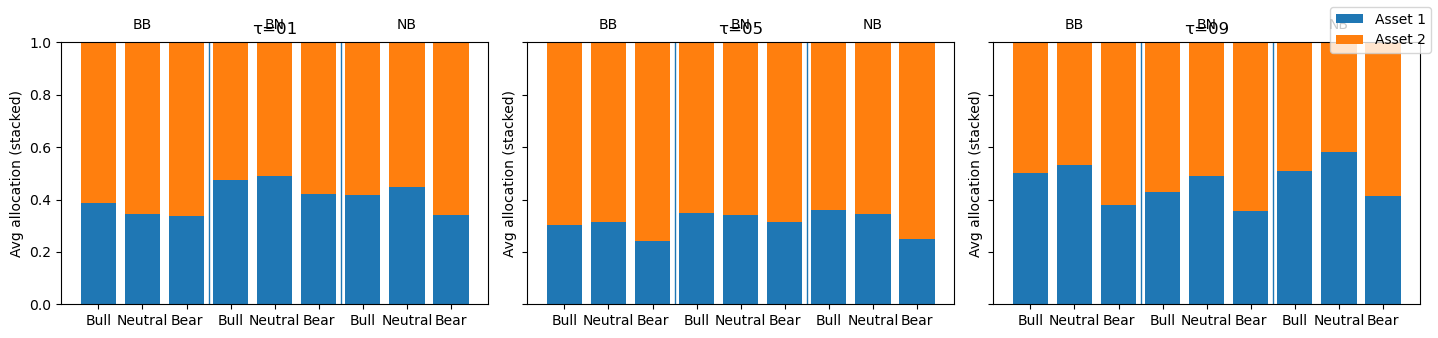

In [42]:

def _iter_payloads_for_tau(nested_scenario, tau_str):
    if tau_str not in nested_scenario:
        return
    by_train = nested_scenario[tau_str]
    for _train_seed, by_test in by_train.items():
        if not isinstance(by_test, dict):
            continue
        for _test_seed, payload in by_test.items():
            if isinstance(payload, dict):
                yield payload


def avg_allocations_by_regime(nested_scenario, tau_str, weights_key="weights", regime_key="regime_days"):
    """
    Returns avg_w: (3, N) for regimes [Bull(0), Neutral(1), Bear(2)]
    averaging over all (train_seed, test_seed) paths and weighting by #days in regime.
    """
    sum_w = None
    cnt = np.zeros(3, dtype=np.float64)

    for payload in _iter_payloads_for_tau(nested_scenario, tau_str):
        w = payload.get(weights_key, None)
        k = payload.get(regime_key, None)
        if w is None or k is None:
            continue

        w = np.asarray(w, dtype=np.float64)
        k = np.asarray(k, dtype=int)

        T = min(len(k), w.shape[0])
        if T <= 1:
            continue

        # drop t=0 initial condition
        w = w[1:T]
        k = k[1:T]

        N = w.shape[1]
        if sum_w is None:
            sum_w = np.zeros((3, N), dtype=np.float64)

        for reg in (0, 1, 2):
            mask = (k == reg)
            c = int(mask.sum())
            if c == 0:
                continue
            sum_w[reg] += w[mask].sum(axis=0)
            cnt[reg] += c

    if sum_w is None:
        raise ValueError(f"No usable payloads found for tau={tau_str} (check keys/paths).")

    avg_w = sum_w / np.maximum(cnt[:, None], 1.0)
    # renormalize per regime
    avg_w = np.clip(avg_w, 0.0, np.inf)
    avg_w /= np.maximum(avg_w.sum(axis=1, keepdims=True), 1e-12)
    return avg_w


# ---------- plotting with correct ordering + labels ----------
def plot_regime_allocations_panels(
    nested_by_scenario,
    tau_str_list=("01", "05", "09"),
    scenario_order=("BB", "BN", "NB"),
    regime_names=("Bull", "Neutral", "Bear"),
    asset_names=("Asset 1", "Asset 2"),
    title_prefix="τ=",
):
    """
    For each tau subplot:
      9 bars in order:
        BB-Bull, BB-Neutral, BB-Bear,
        BN-Bull, BN-Neutral, BN-Bear,
        NB-Bull, NB-Neutral, NB-Bear
    X labels:
      - top row: BB / BN / NB over each 3-bar group
      - bottom row: Bull Neutral Bear repeated
    Legend:
      - asset_names
    """
    n_taus = len(tau_str_list)
    fig, axes = plt.subplots(1, n_taus, figsize=(4.8 * n_taus, 3.4), sharey=True)
    if n_taus == 1:
        axes = [axes]

    for ax, tau_str in zip(axes, tau_str_list):
        # build (9, N)
        blocks = []
        for scen in scenario_order:
            avg_w = avg_allocations_by_regime(nested_by_scenario[scen], tau_str)  # (3,N)
            blocks.append(avg_w)
        W = np.vstack(blocks)  # (9,N)

        N = W.shape[1]
        if N != len(asset_names):
            # keep plotting; just auto-name if mismatch
            asset_names_plot = [f"Asset {i+1}" for i in range(N)]
        else:
            asset_names_plot = list(asset_names)

        x = np.arange(9)
        bottom = np.zeros(9, dtype=float)
        for j in range(N):
            ax.bar(x, W[:, j], bottom=bottom, width=0.8, label=asset_names_plot[j])
            bottom += W[:, j]

        ax.set_ylim(0, 1.0)
        ax.set_title(f"{title_prefix}{tau_str}")
        ax.set_ylabel("Avg allocation (stacked)")

        # bottom labels: Bull/Neutral/Bear repeated
        ax.set_xticks(x)
        ax.set_xticklabels(list(regime_names) * 3)

        # vertical separators between scenario groups
        ax.axvline(2.5, linewidth=1)
        ax.axvline(5.5, linewidth=1)

        # top labels (scenario) centered over each group of 3 bars
        for scen, cx in zip(scenario_order, [1, 4, 7]):
            ax.text(cx, 1.04, scen, ha="center", va="bottom", transform=ax.get_xaxis_transform())

        ax.margins(y=0.12)

    # one legend for whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", frameon=True)

    plt.tight_layout()
    plt.show()



nested_by_scenario = {
    "BB": nested_bull_bear,
    "BN": nested_bull_neutral,
    "NB": nested_neutral_bear,
}

plot_regime_allocations_panels(
    nested_by_scenario,
    tau_str_list=("01", "05", "09"),
    scenario_order=("BB", "BN", "NB"),
    regime_names=("Bull", "Neutral", "Bear"),
    asset_names=("Asset 1", "Asset 2"),  # 
)


# Inverse CDF plot
## Measuring Critic Effectiveness
###  Assessment: Heavy tails, No Quantile Crossing, Monoton and more risk seeking crossing below

### Inverse CDF per scenario

In [48]:

_stack_scenarios_to_long(bb_means, bn_means, nb_means)

,regime,w1,w2,cash,scenario,policy,regime_name
0,0,0.215236,0.317902,0.466862,BB,01,Bull
1,1,0.178466,0.263382,0.558152,BB,01,Neutral
2,2,0.181265,0.315226,0.503509,BB,01,Bear
3,0,0.266608,0.445820,0.287571,BB,05,Bull
4,1,0.247509,0.397131,0.355360,BB,05,Neutral
5,2,0.234623,0.421425,0.343952,BB,05,Bear
6,0,0.455789,0.361079,0.183131,BB,09,Bull
7,1,0.388418,0.385458,0.226124,BB,09,Neutral
8,2,0.504329,0.317765,0.177906,BB,09,Bear
9,0,0.255450,0.286354,0.458195,BN,01,Bull


In [19]:
def plot_policy_means_across_scenarios(
    bb_means, bn_means, nb_means,
    scenario_labels=("bull_bear","bull_neutral","neutral_bear"),
    out_dir="plots"
    ):

    os.makedirs(out_dir, exist_ok=True)

    policy_title = {
        "tau_01": "Risk-averse Policy (τ=0.1)",
        "tau_05": "Risk-neutral Policy (τ=0.5)",
        "tau_09": "Risk-seeking Policy (τ=0.9)",
    }

    scenarios = [bb_means, bn_means, nb_means]
    labels = list(scenario_labels)

    # map regime numbers to names
    regime_labels = {0: "Bull", 1: "Neutral", 2: "Bear"}

    # find all policies across scenarios: 0.1,0.5,0.9
    all_policies = set().union(*[set(s.keys()) for s in scenarios])

    saved = []
    for policy in sorted(all_policies):
        # gather available dataframes for this policy
        dfs, available_labels = [], []
        for scen, lab in zip(scenarios, labels):
            if policy in scen:
                dfs.append(scen[policy]) # tau i.e 0.1
                available_labels.append(lab)
        if not dfs:
            continue

        regimes = dfs[0]["regime"].values # Same regimes and order across scenarios: yes as we did before

        fig, axes = plt.subplots(1, 3, figsize=(12, 4.0), sharex=True)
        fig.suptitle(policy_title.get(policy, policy.replace("tau_", "Policy τ=0.")), fontsize=12, y=1.02)

        comps = ["w1", "w2", "cash"]
        titles = ["Asset 1 weight by regime", "Asset 2 weight by regime", "Cash weight by regime"]

        for ax, comp, ttl in zip(axes, comps, titles):
            for df, lab in zip(dfs, available_labels):
                ax.plot(regimes, df[comp].values, marker="o", label=lab) # get w1,w2 and cash
            ax.set_title(ttl, fontsize=10)
            ax.set_xlabel("Regime")
            ax.set_ylabel("Mean weight")
            ax.set_xticks(regimes)
            ax.set_xticklabels([regime_labels.get(r, str(r)) for r in regimes])
            ax.grid(True, alpha=0.3)

        axes[0].legend(title="Scenario", loc="best", frameon=False)
        fig.tight_layout()

        fname = f"{policy}_means_by_regime.png"
        fpath = os.path.join(out_dir, fname)
        plt.savefig(fpath, dpi=200, bbox_inches="tight")
        plt.close(fig)
        saved.append(fpath)

    return saved

# usage
saved_paths = plot_policy_means_across_scenarios(
    bb_means, bn_means, nb_means,
    scenario_labels=("BB","BN","NB"),
    out_dir="policy_plots"
)
print("Saved:", *saved_paths, sep="\n- ")


Saved:
- policy_plots\01_means_by_regime.png
- policy_plots\05_means_by_regime.png
- policy_plots\09_means_by_regime.png


### Summary tables

## Robustness check

### Cash focus, we have changed the constant and variance term ( Variance matters a lot, constant change is not enough)


## Load files with evaluated training

# Multiple Cost analysis
## Value Function and Share analysis
### If someone wants to check the outcome over different costs. 
#### I experienced no exploration... Need a better set up